In [41]:
import sys
import os
import numpy as np
import pandas as pd
import networkx as nx
from collections import OrderedDict
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdchem import Mol
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D,MolToImage,ShowMol,IPythonConsole,rdMolDraw2D
from cairosvg import svg2png
from IPython.display import SVG
import tempfile

In [2]:
def nobleize(file,replacing,replace_with,verbose=False):
    df=pd.read_csv(file)
    smiles=df['SMILES'].to_list()
    
    nobleized_smiles=[]
    
    for s in smiles:
        m=Chem.MolFromSmiles(s)
        mod_mol = Chem.ReplaceSubstructs(m, 
                                Chem.MolFromSmiles(replacing),
                                 Chem.MolFromSmiles(replace_with),
                                 replaceAll=False)
        for mod in mod_mol:
            if '.' not in Chem.MolToSmiles(mod):
                nobleized_smiles.append(Chem.MolToSmiles(mod))
            else:
                if verbose:
                    print(f'Check your substructure queries, there is a . appearing in the SMILES string after replacement')
    return nobleized_smiles

    

In [3]:
def topology_from_rdkit(rdkit_molecule):

    topology = nx.Graph()
    for atom in rdkit_molecule.GetAtoms():
        # Add the atoms as nodes
        topology.add_node(atom.GetIdx())

        # Add the bonds as edges
        for bonded in atom.GetNeighbors():
            topology.add_edge(atom.GetIdx(), bonded.GetIdx())

    return topology


def is_isomorphic(topology1, topology2):
    return nx.is_isomorphic(topology1, topology2)

## Carboxylic Acids

In [5]:
#Aggregate all files together and make one smiles list

carb_acid_dir='../carboxylic_acids'
file_list=[]
for filename in os.listdir(carb_acid_dir):
    f = os.path.join(carb_acid_dir, filename)
    # checking if it is a file
    if os.path.isfile(f):
        file_list.append(filename)
file_list.sort()
file_list

['Reaxys_Exp_20220223_213007_0-1000.xlsx',
 'Reaxys_Exp_20220223_215352_1001-2000.xlsx',
 'Reaxys_Exp_20220223_215832_2000-3000.xlsx',
 'Reaxys_Exp_20220223_220357_3001-4000.xlsx',
 'Reaxys_Exp_20220223_220541_4001-5000.xlsx',
 'Reaxys_Exp_20220223_220730_5001-6000.xlsx',
 'Reaxys_Exp_20220223_220937_6001-7000.xlsx',
 'Reaxys_Exp_20220223_221138_7001-8000.xlsx',
 'Reaxys_Exp_20220223_221336_8001-9000.xlsx',
 'Reaxys_Exp_20220223_221600_9001-10000.xlsx',
 'Reaxys_Exp_20220301_175831_10001-11000.xlsx',
 'Reaxys_Exp_20220301_180912_11001-12000.xlsx',
 'Reaxys_Exp_20220301_181208_12001-13000.xlsx',
 'Reaxys_Exp_20220301_181636_13001-14000.xlsx',
 'Reaxys_Exp_20220301_181842_14001-15000.xlsx',
 'Reaxys_Exp_20220301_182120_15001-16000.xlsx',
 'Reaxys_Exp_20220301_182435_16001-17000.xlsx',
 'Reaxys_Exp_20220301_182702_17001-18000.xlsx',
 'Reaxys_Exp_20220301_182910_18001-19000.xlsx',
 'Reaxys_Exp_20220301_183237_19001-20000.xlsx',
 'Reaxys_Exp_20220302_214122_20001-21000.xlsx',
 'Reaxys_Exp_2

In [7]:
smiles_list=[]
for f in file_list:
    filename=f'../carboxylic_acids/{f}'
    df=pd.read_excel(filename)
    smiles_list=smiles_list + df['SMILES'].to_list()[0:-3] #The -3 indexing removes some junk at the end of the file from the Reaxys export

In [9]:
cleaned_mols=[] #Has a carboxylic acid, but can also have ester groups
ester_only_list=[] #Does not contain carboxylic acids
unaccounted_mols=[]

ester=Chem.MolFromSmiles('CC(OC)=O')
#carboxylic_acid=Chem.MolFromSmarts('[CX3](=O)[OX2H1]')#Need to use the SMARTS string here
carboxylic_acid=Chem.MolFromSmarts('[O;H,-]C=O')#Need to use the SMARTS string here

nitro_ester=Chem.MolFromSmiles('CC(ON)=O')
deprot_carboxylic_acid=Chem.MolFromSmiles('[O-]C(C)=O')
mol=[]
count=0

for i,s in enumerate(smiles_list):
    
    m=Chem.MolFromSmiles(s)
    mol.append(m)
    try:
        if m.HasSubstructMatch(ester) and m.HasSubstructMatch(carboxylic_acid)==False: #Ester but not carboylic acid
            #print(f'Structure {i+1}: pattern found {m.HasSubstructMatch(pattern1)}')
            ester_only_list.append(m) #Does not contain carboxylic acid
            count+=1
        elif m.HasSubstructMatch(carboxylic_acid):
            cleaned_mols.append(m) #Has carboxylic acid but can also have an ester group
        else:
            unaccounted_mols.append(m)
    except:
        print(f'Molecule {s} at position {i} threw an error')
        
print(f'There are {count} molecules with no carboxylic acids')


RDKit ERROR: [13:33:59] Explicit valence for atom # 4 N, 5, is greater than permitted
RDKit ERROR: [13:33:59] Explicit valence for atom # 5 N, 5, is greater than permitted


Molecule OC(=O)C[N]=1=NOC(=O)C=1 at position 1115 threw an error
Molecule OC(=O)CC[N]=1=NOC(=O)C=1 at position 2171 threw an error


RDKit ERROR: [13:34:00] Explicit valence for atom # 9 N, 5, is greater than permitted


Molecule CC(=O)OC1CC(C)(C)[N](#[OH])C(C)(C)C1 at position 14346 threw an error
Molecule [Fe++]123456789[C@H-]%10[CH]1=[CH]2[CH]3=[CH]4%10.OC(=O)C[C]51=[CH]6[C@@H-]7[CH]8=[CH]91 at position 20591 threw an error
There are 4189 molecules with no carboxylic acids


RDKit ERROR: [13:34:00] Explicit valence for atom # 1 C, 5, is greater than permitted


In [10]:
len(ester_only_list)

4189

/home/gridsan/jmaalouf/.local/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


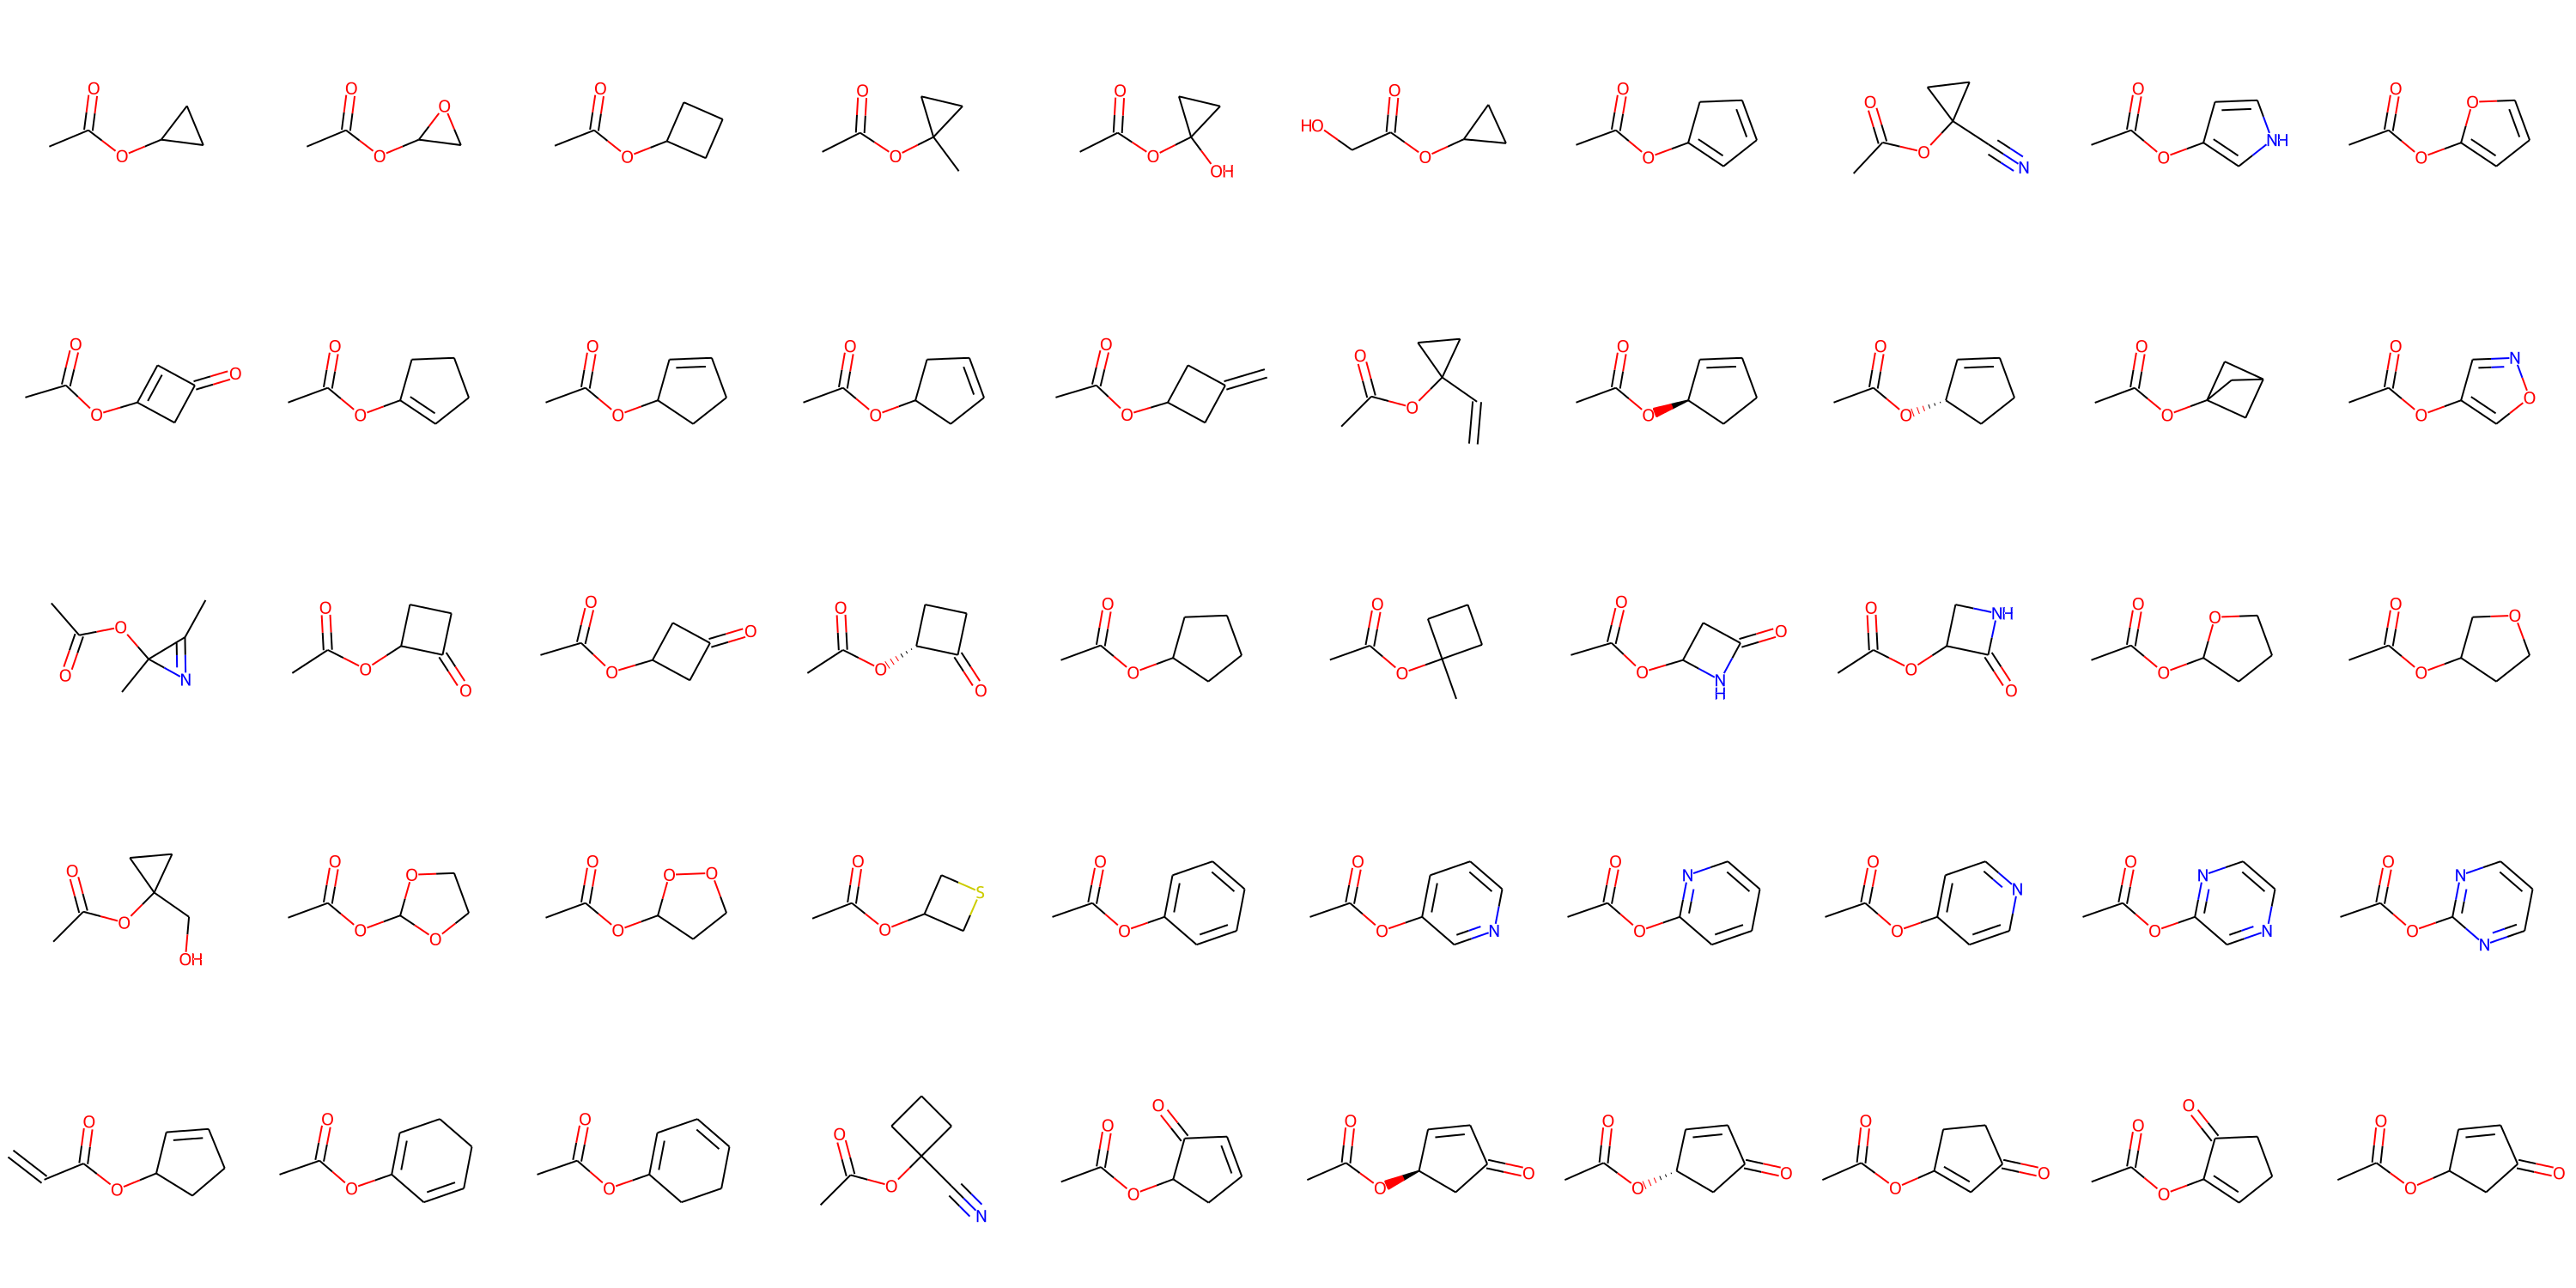

In [10]:
Chem.Draw.MolsToGridImage(ester_only_list, molsPerRow=10,subImgSize=(300,300))

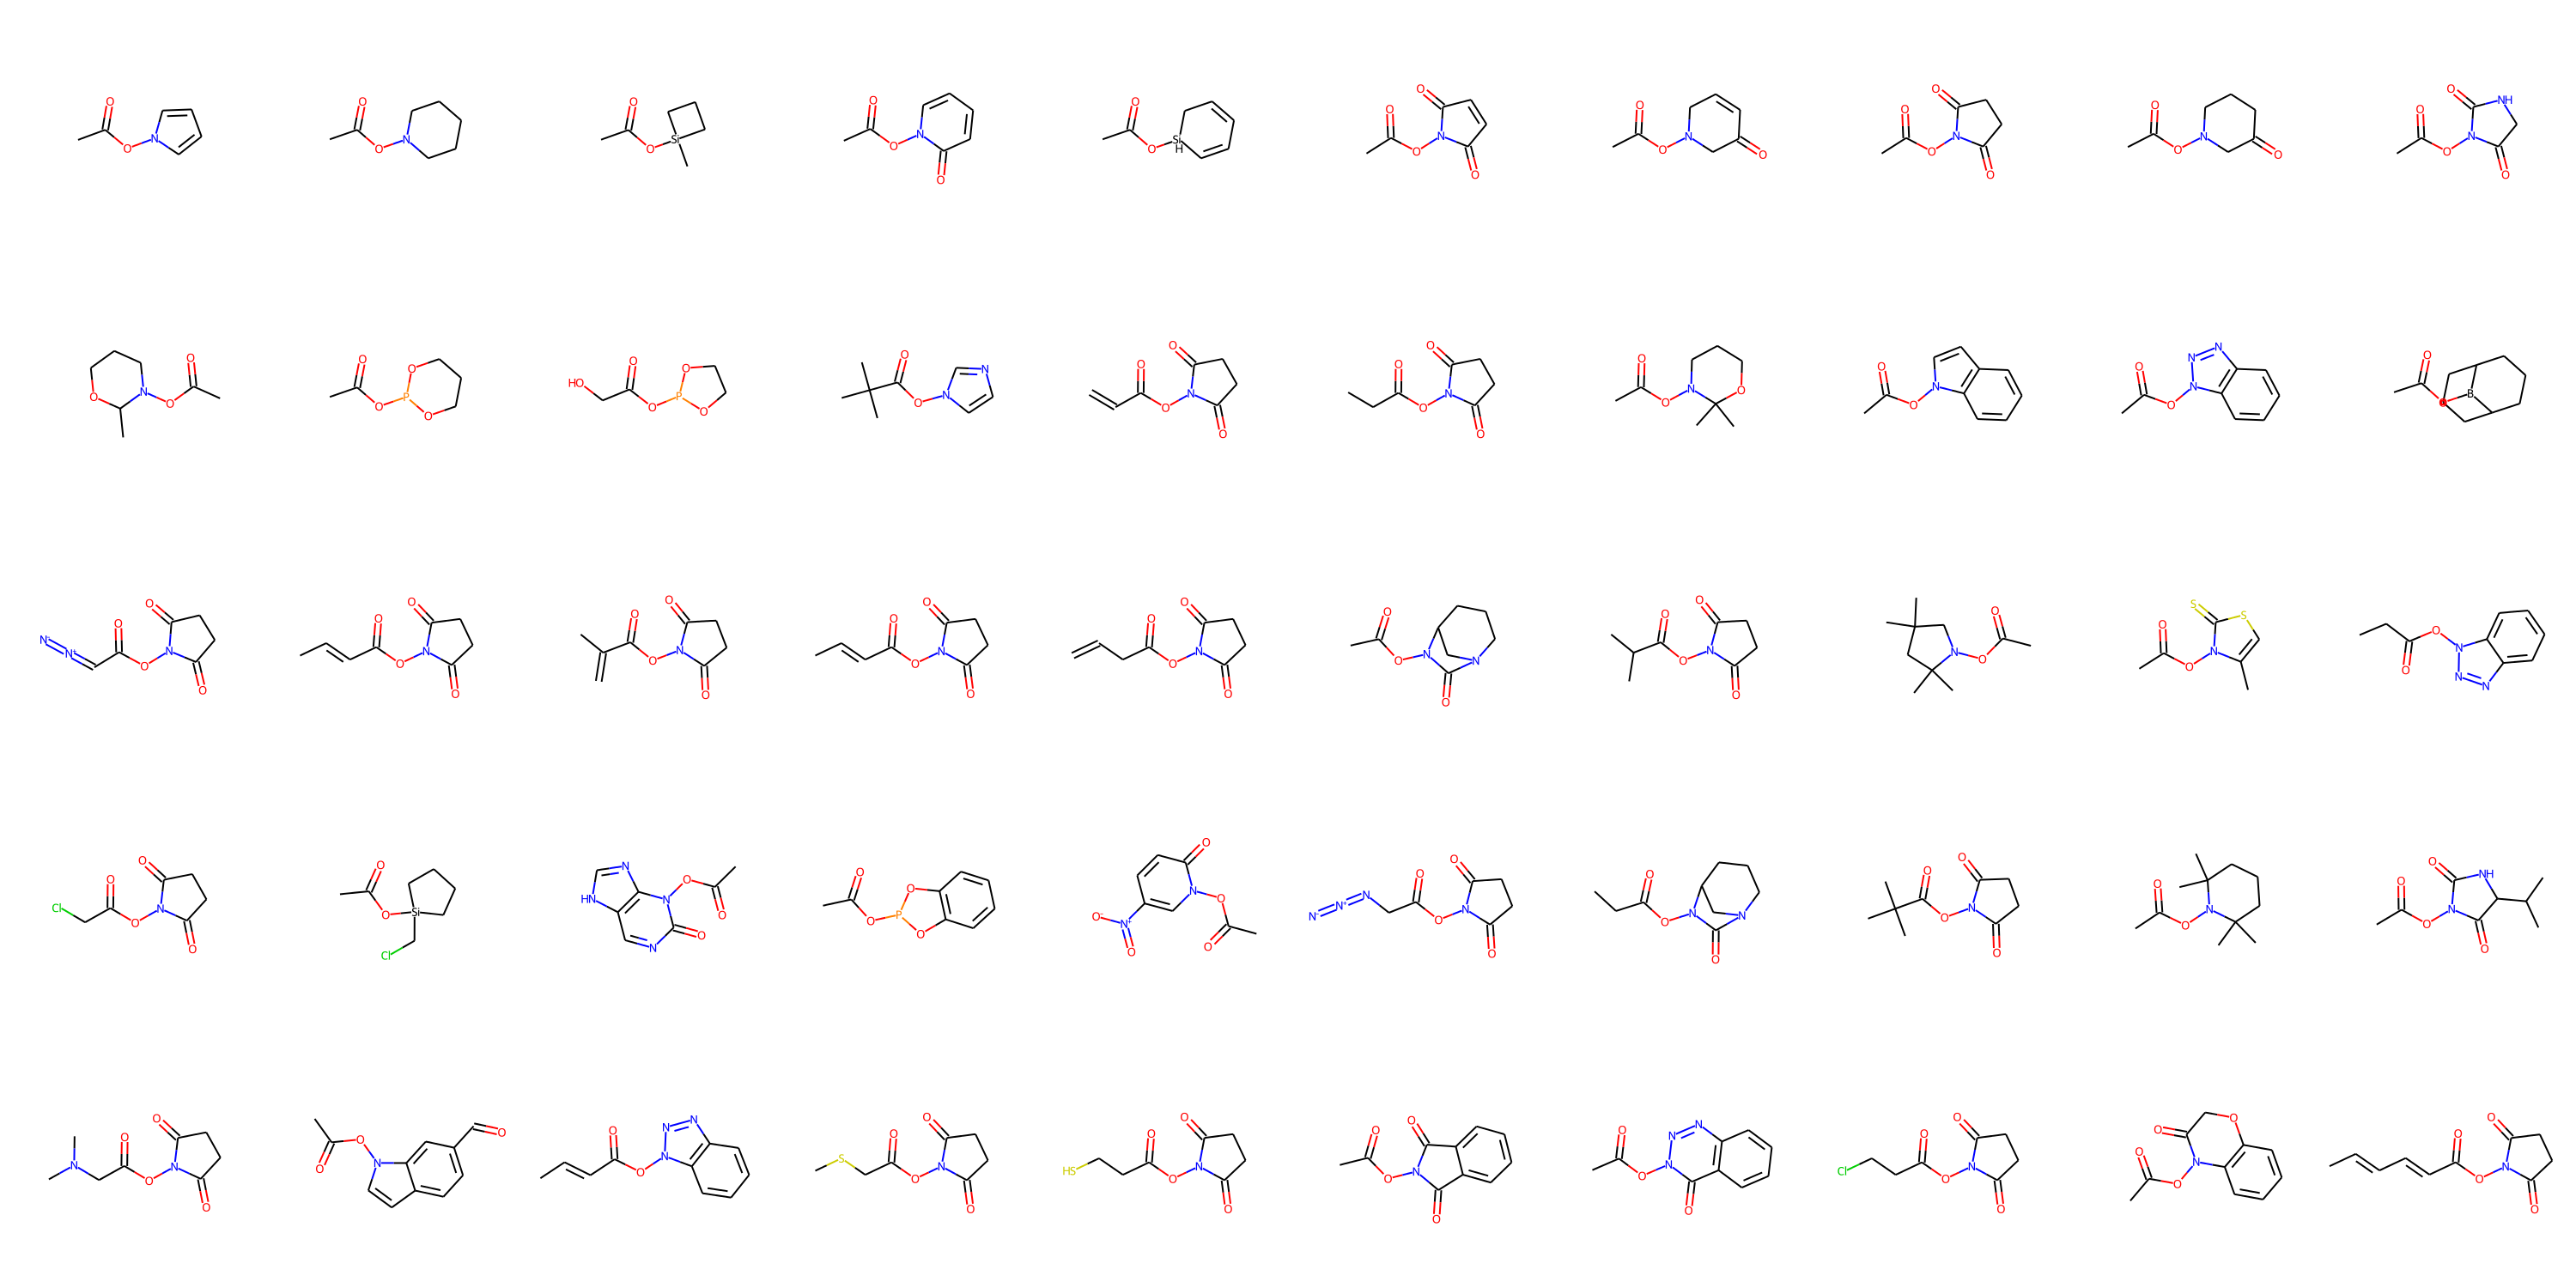

In [8]:
Chem.Draw.MolsToGridImage(unaccounted_mols, molsPerRow=10,subImgSize=(300,300))

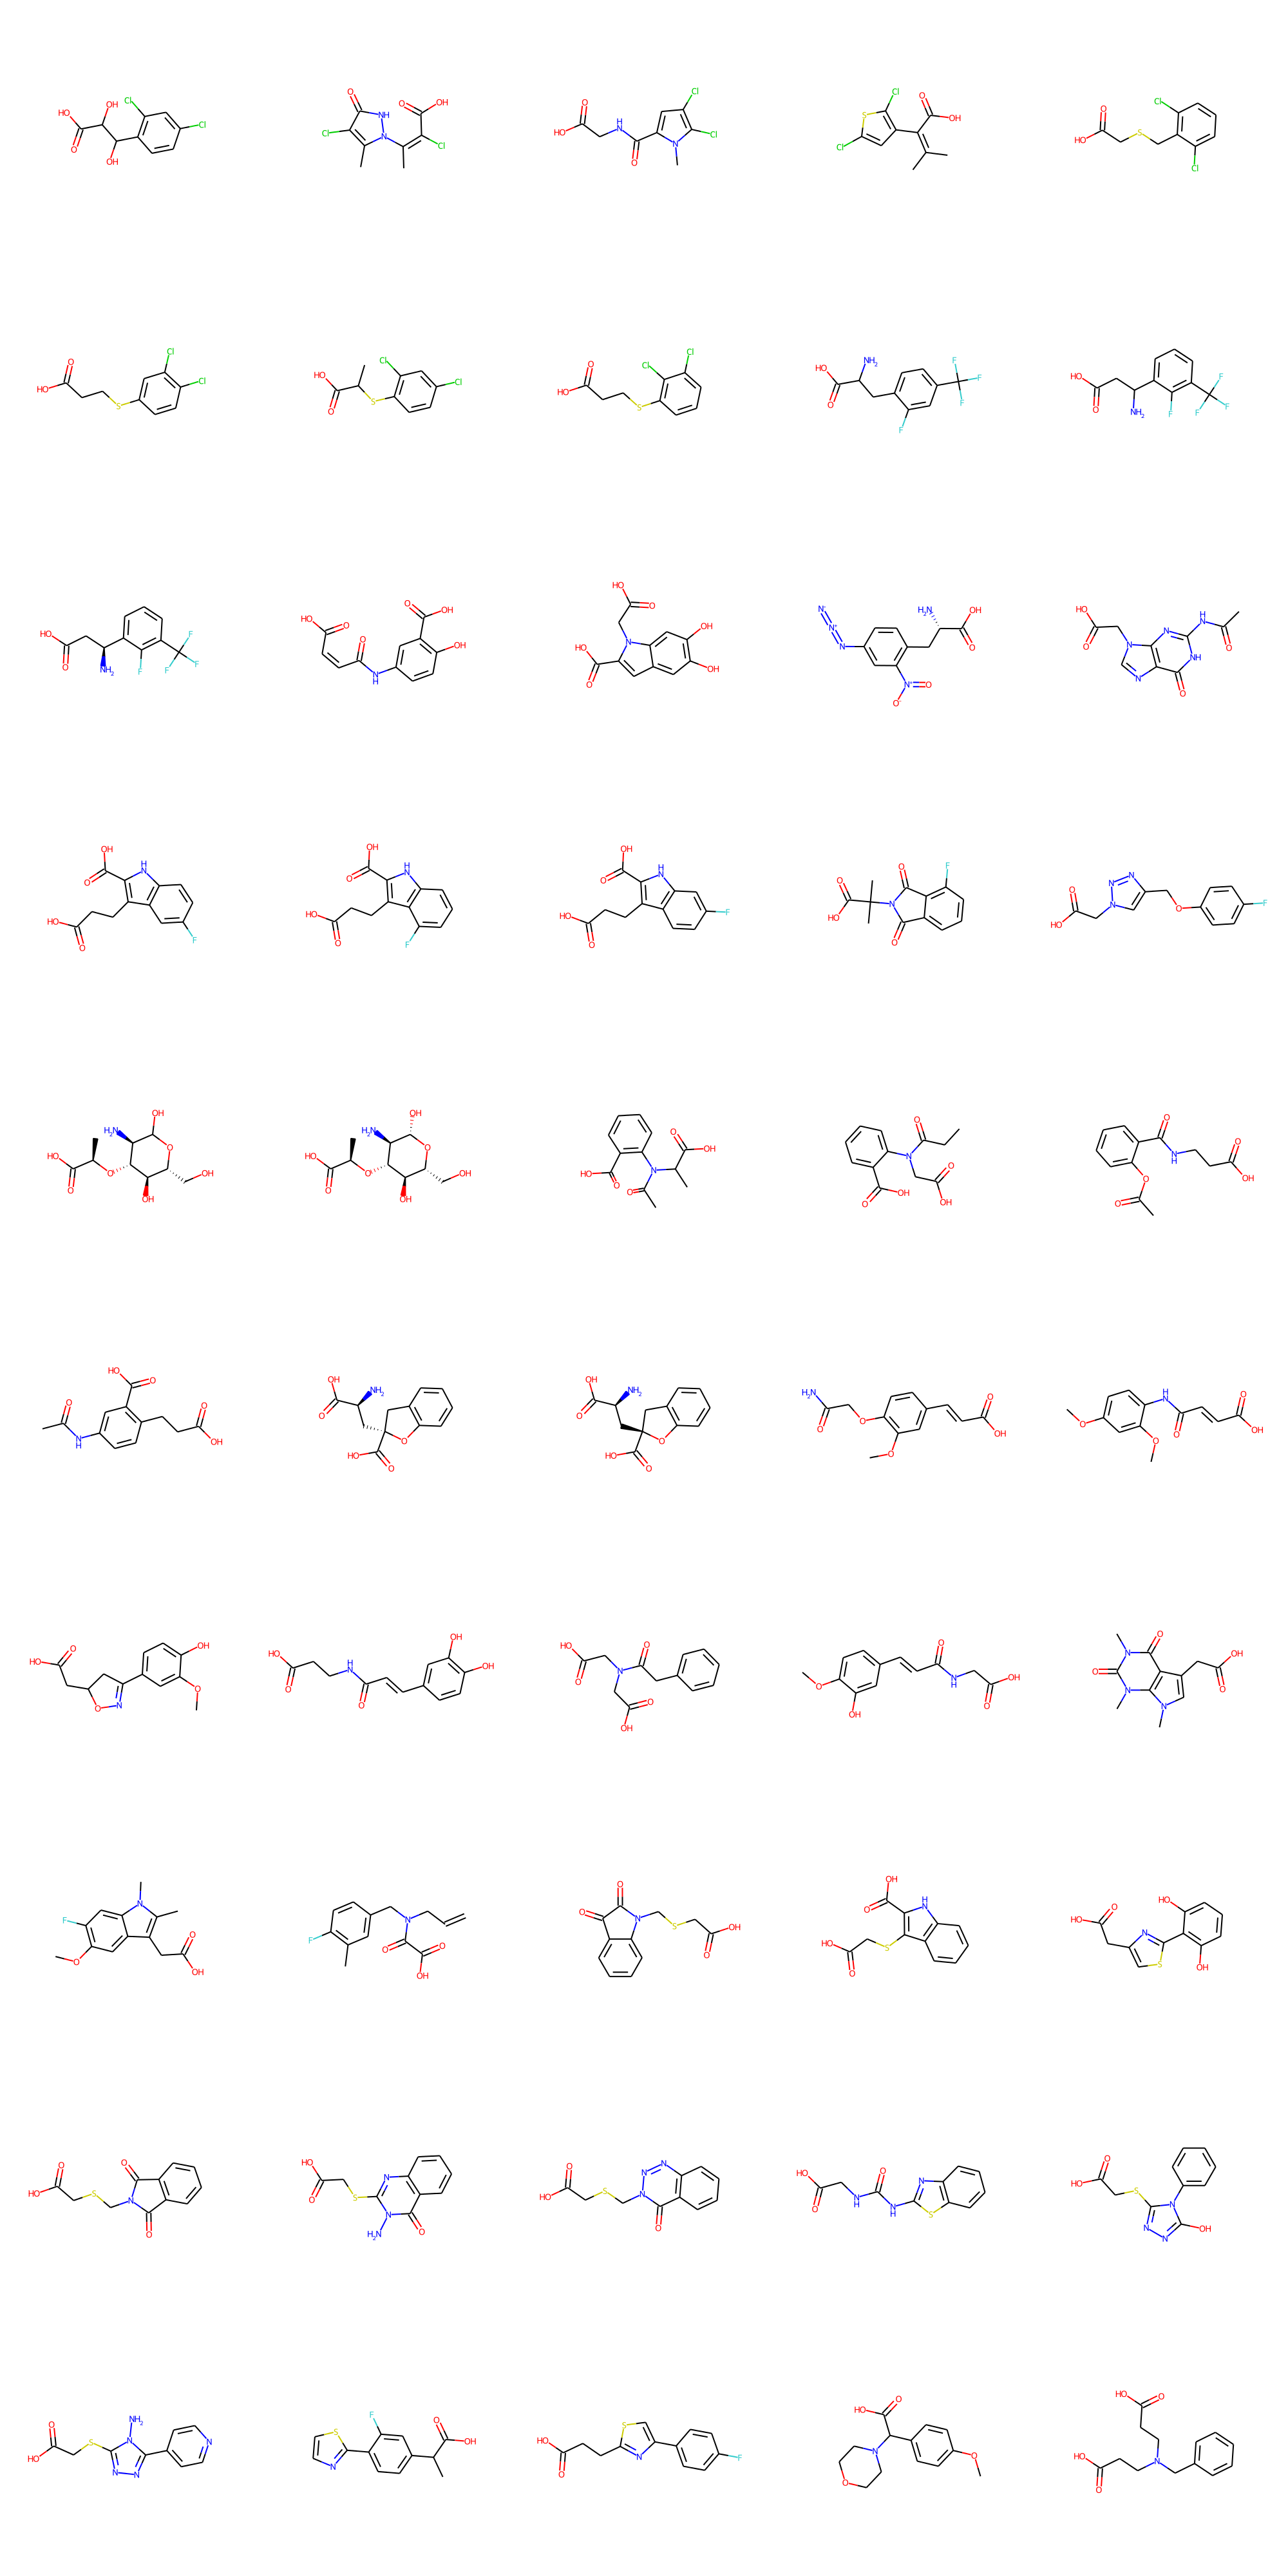

In [9]:
Chem.Draw.MolsToGridImage(cleaned_mols[-100:-1], molsPerRow=5,subImgSize=(400,400))

In [11]:
#Goal is to remove specific atoms from the list, including As,Se, and maybe B

mols_to_remove=[]
atom_set=set()
for i,m in enumerate(cleaned_mols):
    

    try:
        for a in m.GetAtoms():
            #atom_set.add(a.GetSymbol())
            
            if a.GetSymbol()=='As' or a.GetSymbol()=='Se' or a.GetSymbol()=='B' or a.GetSymbol()=='Si': 
                print(f'{a.GetSymbol()} found at position {i} of molecule {Chem.MolToSmiles(m)}')
                
                mols_to_remove.append(i)
                break
    except:
        print(f'Molecule at position {i} threw an error')
        



Si found at position 610 of molecule C[Si](C)(C)CC(=O)O
Si found at position 1050 of molecule C[Si](C)(C)/C=C/C(=O)O
Si found at position 1051 of molecule C=C(C(=O)O)[Si](C)(C)C
Si found at position 1052 of molecule C[Si](C)(C)/C=C\C(=O)O
Si found at position 1164 of molecule C[Si](C)(C)CCC(=O)O
Si found at position 1165 of molecule CC(C(=O)O)[Si](C)(C)C
Si found at position 1166 of molecule CC[Si](C)(C)CC(=O)O
Si found at position 1214 of molecule C[Si](C)(C)C(O)C(=O)O
Si found at position 1926 of molecule C=C(C[Si](C)(C)C)C(=O)O
Si found at position 1927 of molecule C=CC(C(=O)O)[Si](C)(C)C
Si found at position 1928 of molecule C[Si](C)(C)/C=C/CC(=O)O
Si found at position 1929 of molecule C[Si](C)(C)C/C=C/C(=O)O
Si found at position 2057 of molecule CC(C[Si](C)(C)C)C(=O)O
Si found at position 2058 of molecule CC[Si](C)(CC)CC(=O)O
Si found at position 2059 of molecule CC(C)(C(=O)O)[Si](C)(C)C
Si found at position 2105 of molecule C[Si](C)(C)CC(N)C(=O)O
Si found at position 2106 of mole

In [12]:
atom_cleaned_mols=[cleaned_mols[i] for i in range(len(cleaned_mols)) if i not in mols_to_remove]

In [13]:
cleaned_atom_set=set()
for i,m in enumerate(atom_cleaned_mols):
    
    
    try:
        for a in m.GetAtoms():
            cleaned_atom_set.add(a.GetSymbol()) 
    except:
        print(f'Molecule at position {i} threw an error')

print(cleaned_atom_set)

{'Br', 'O', 'S', 'N', 'F', 'I', 'Cl', 'P', 'C'}


In [14]:
print(f'After all cleaning we are left with {len(atom_cleaned_mols)} carboxylic acids')

After all cleaning we are left with 17586 carboxylic acids


In [15]:
atom_cleaned_smiles=[]
for m in atom_cleaned_mols:
    atom_cleaned_smiles.append(Chem.MolToSmiles(m))
    

In [16]:
df=pd.DataFrame(atom_cleaned_smiles,columns=['SMILES'])
df.to_csv('Carboxylic_Acids.csv')

## Remove Duplicate Acids

In [17]:
df=pd.read_csv('Carboxylic_Acids.csv')

In [20]:
ca=df['SMILES'].to_list()
ca_2=list(OrderedDict.fromkeys(ca)) #Removes smiles strings that are the same

In [17]:
#Now we need to check if there are duplicate molecular graphs

In [18]:
[topology_from_rdkit(Chem.MolFromSmiles('CCCCCC'))]

In [21]:
ca_networks=[]

for i,s in enumerate(tqdm(ca_2)):
    m=Chem.MolFromSmiles(s)
    top=topology_from_rdkit(m)
    ca_networks.append(top)
        

 99%|█████████▊| 66/67 [00:00<00:00, 2582.55it/s]


TypeError: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float

In [21]:
df_cleaned=pd.DataFrame(ca_2,columns=['SMILES'])
df_cleaned.to_csv('Carboxylic_Acids_Cleaned.csv')

/home/gridsan/jmaalouf/.local/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


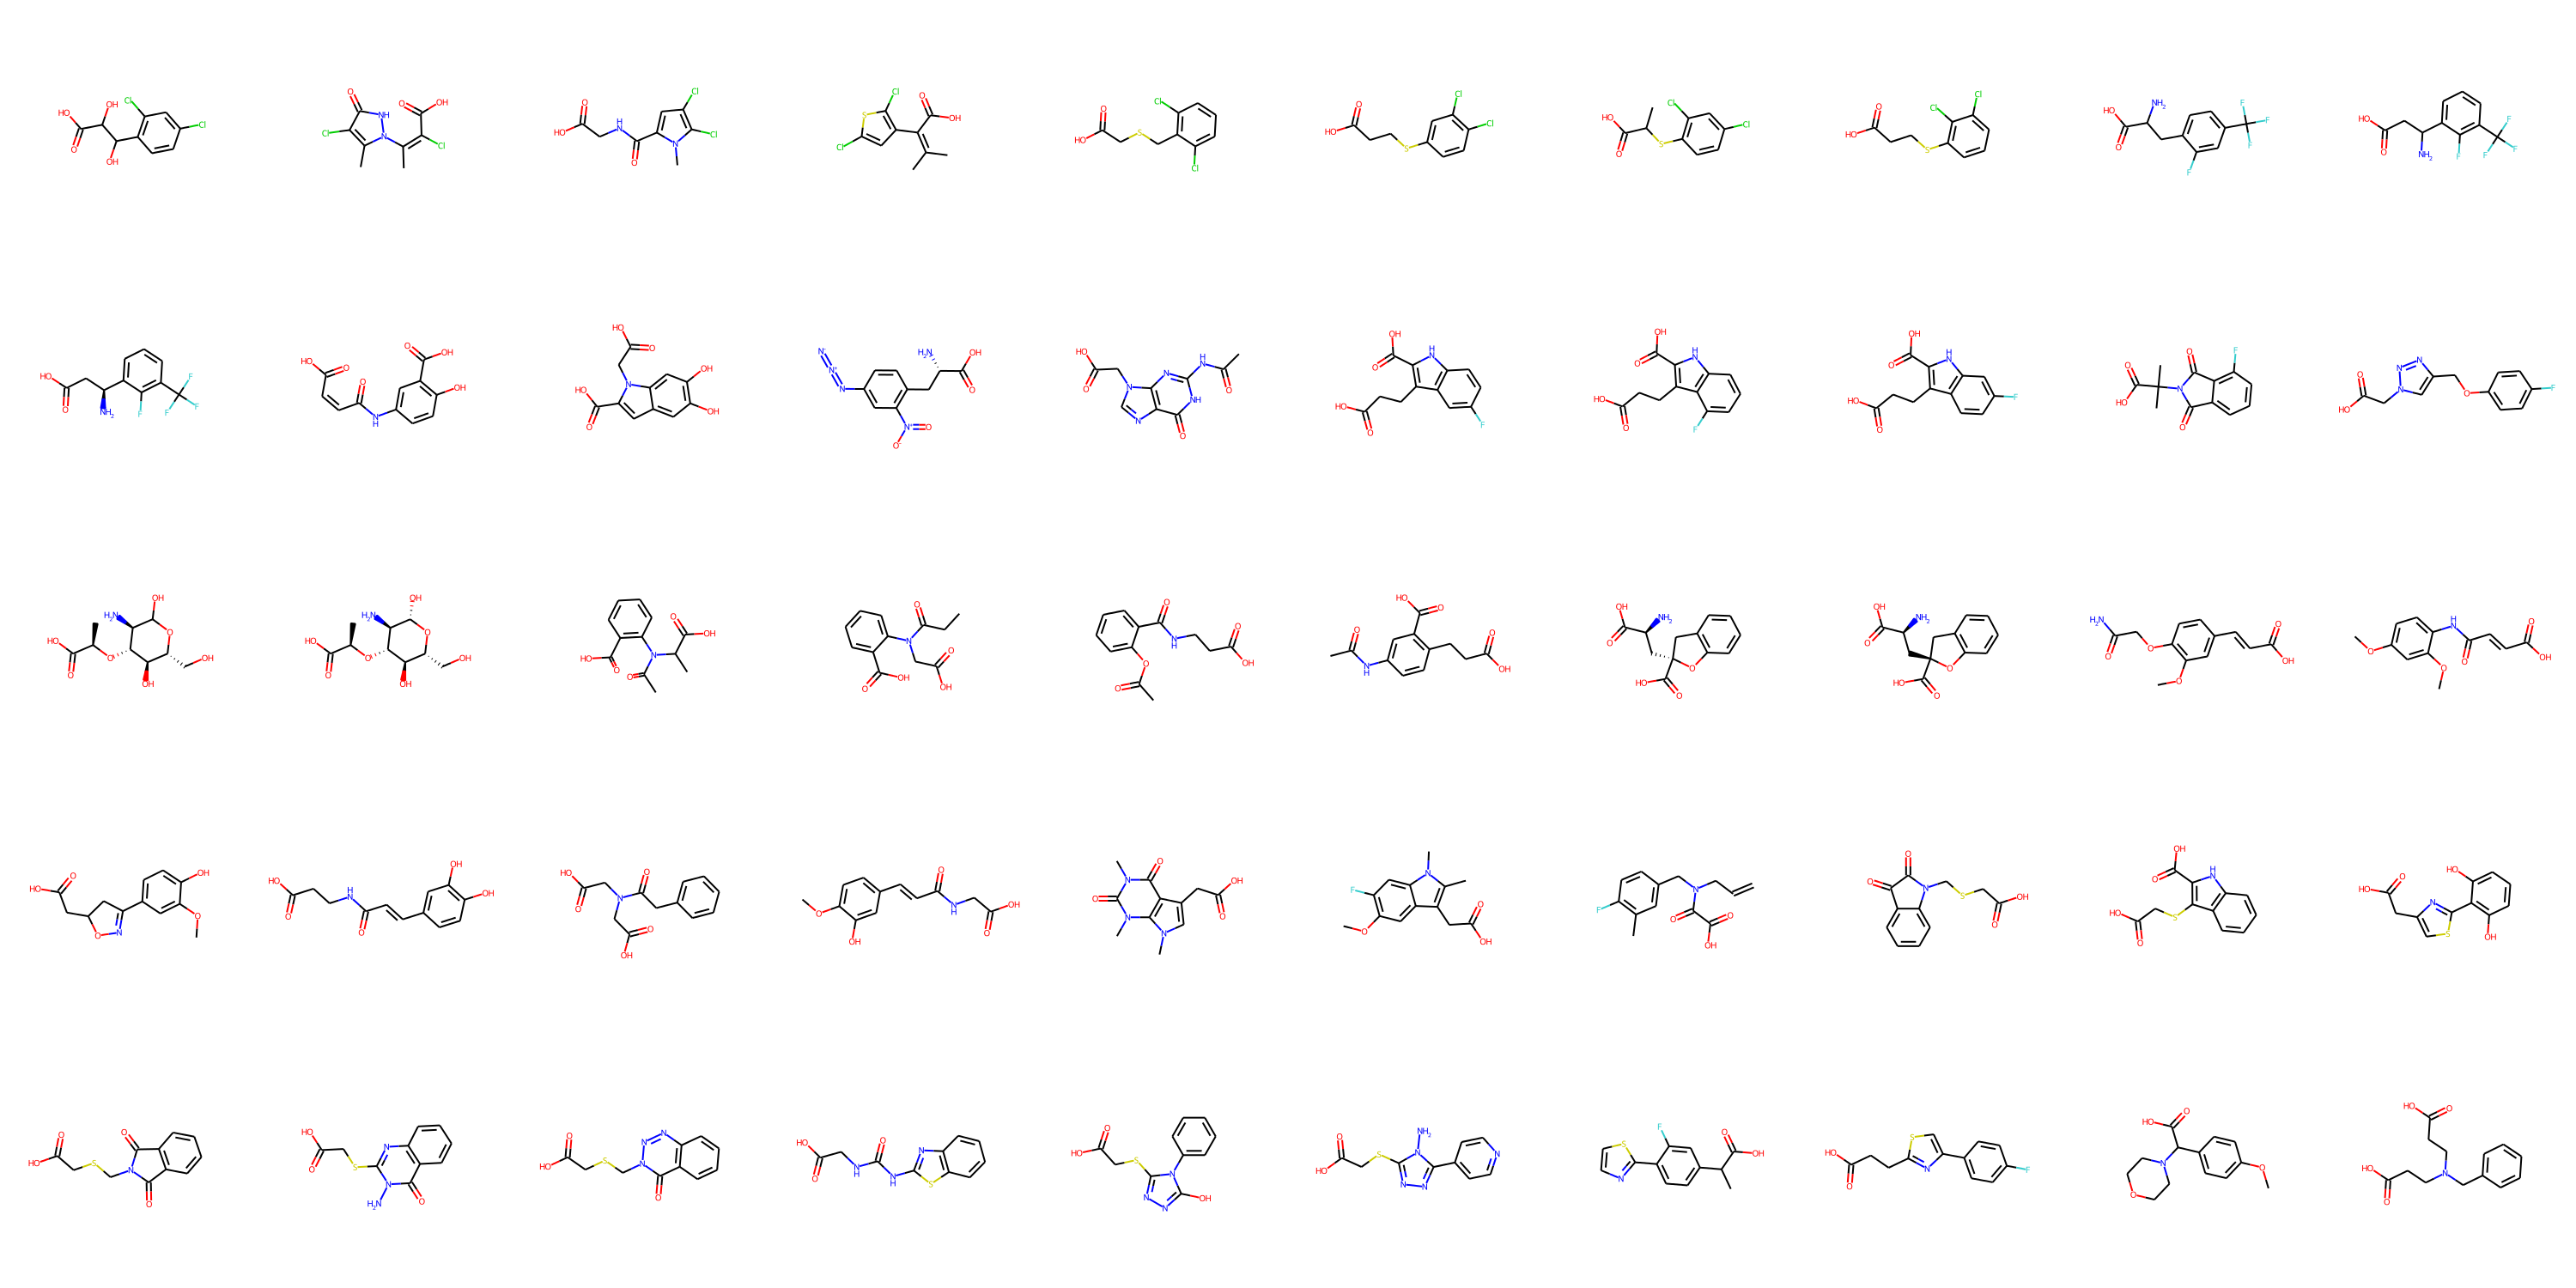

In [15]:
Chem.Draw.MolsToGridImage(atom_cleaned_mols[-100:-1], molsPerRow=10,subImgSize=(300,300))

In [23]:
noble_acids=nobleize('../sheets/Carboxylic_Acids_Cleaned.csv','C(=O)O','C(=O)[Ar]')

In [28]:
ylides=[]
ylide_smiles=[]
for na in tqdm(noble_acids):
    
    combo=Chem.ReplaceSubstructs(Chem.MolFromSmiles(na), 
                                Chem.MolFromSmiles('[Ar]'),
                                 Chem.MolFromSmiles('[N-][N+](C)(C)(C)'), 
                                 replaceAll=False)
    for c in combo:
        ylides.append(c)
        ylide_smiles.append(Chem.MolToSmiles(c))

100%|██████████| 19097/19097 [00:03<00:00, 6275.63it/s]


In [24]:
ylides_rad=[]
ylide_rad_smiles=[]

for na in tqdm(noble_acids):
    
    combo=Chem.ReplaceSubstructs(Chem.MolFromSmiles(na), 
                                Chem.MolFromSmiles('[Ar]'),
                                 Chem.MolFromSmiles('[N][N+](C)(C)(C)'), 
                                 replaceAll=False)
    for c in combo:
        ylides_rad.append(c)
        ylide_rad_smiles.append(Chem.MolToSmiles(c))
        
        

100%|██████████| 19097/19097 [00:03<00:00, 6057.16it/s]


In [25]:
ylides_h=[]
ylide_h_smiles=[]

for na in tqdm(noble_acids):
    
    combo=Chem.ReplaceSubstructs(Chem.MolFromSmiles(na), 
                                Chem.MolFromSmiles('[Ar]'),
                                 Chem.MolFromSmiles('[NH][N+](C)(C)(C)'), 
                                 replaceAll=False)
    for c in combo:
        ylides_h.append(c)
        ylide_h_smiles.append(Chem.MolToSmiles(c)) 

100%|██████████| 19097/19097 [00:03<00:00, 6070.20it/s]


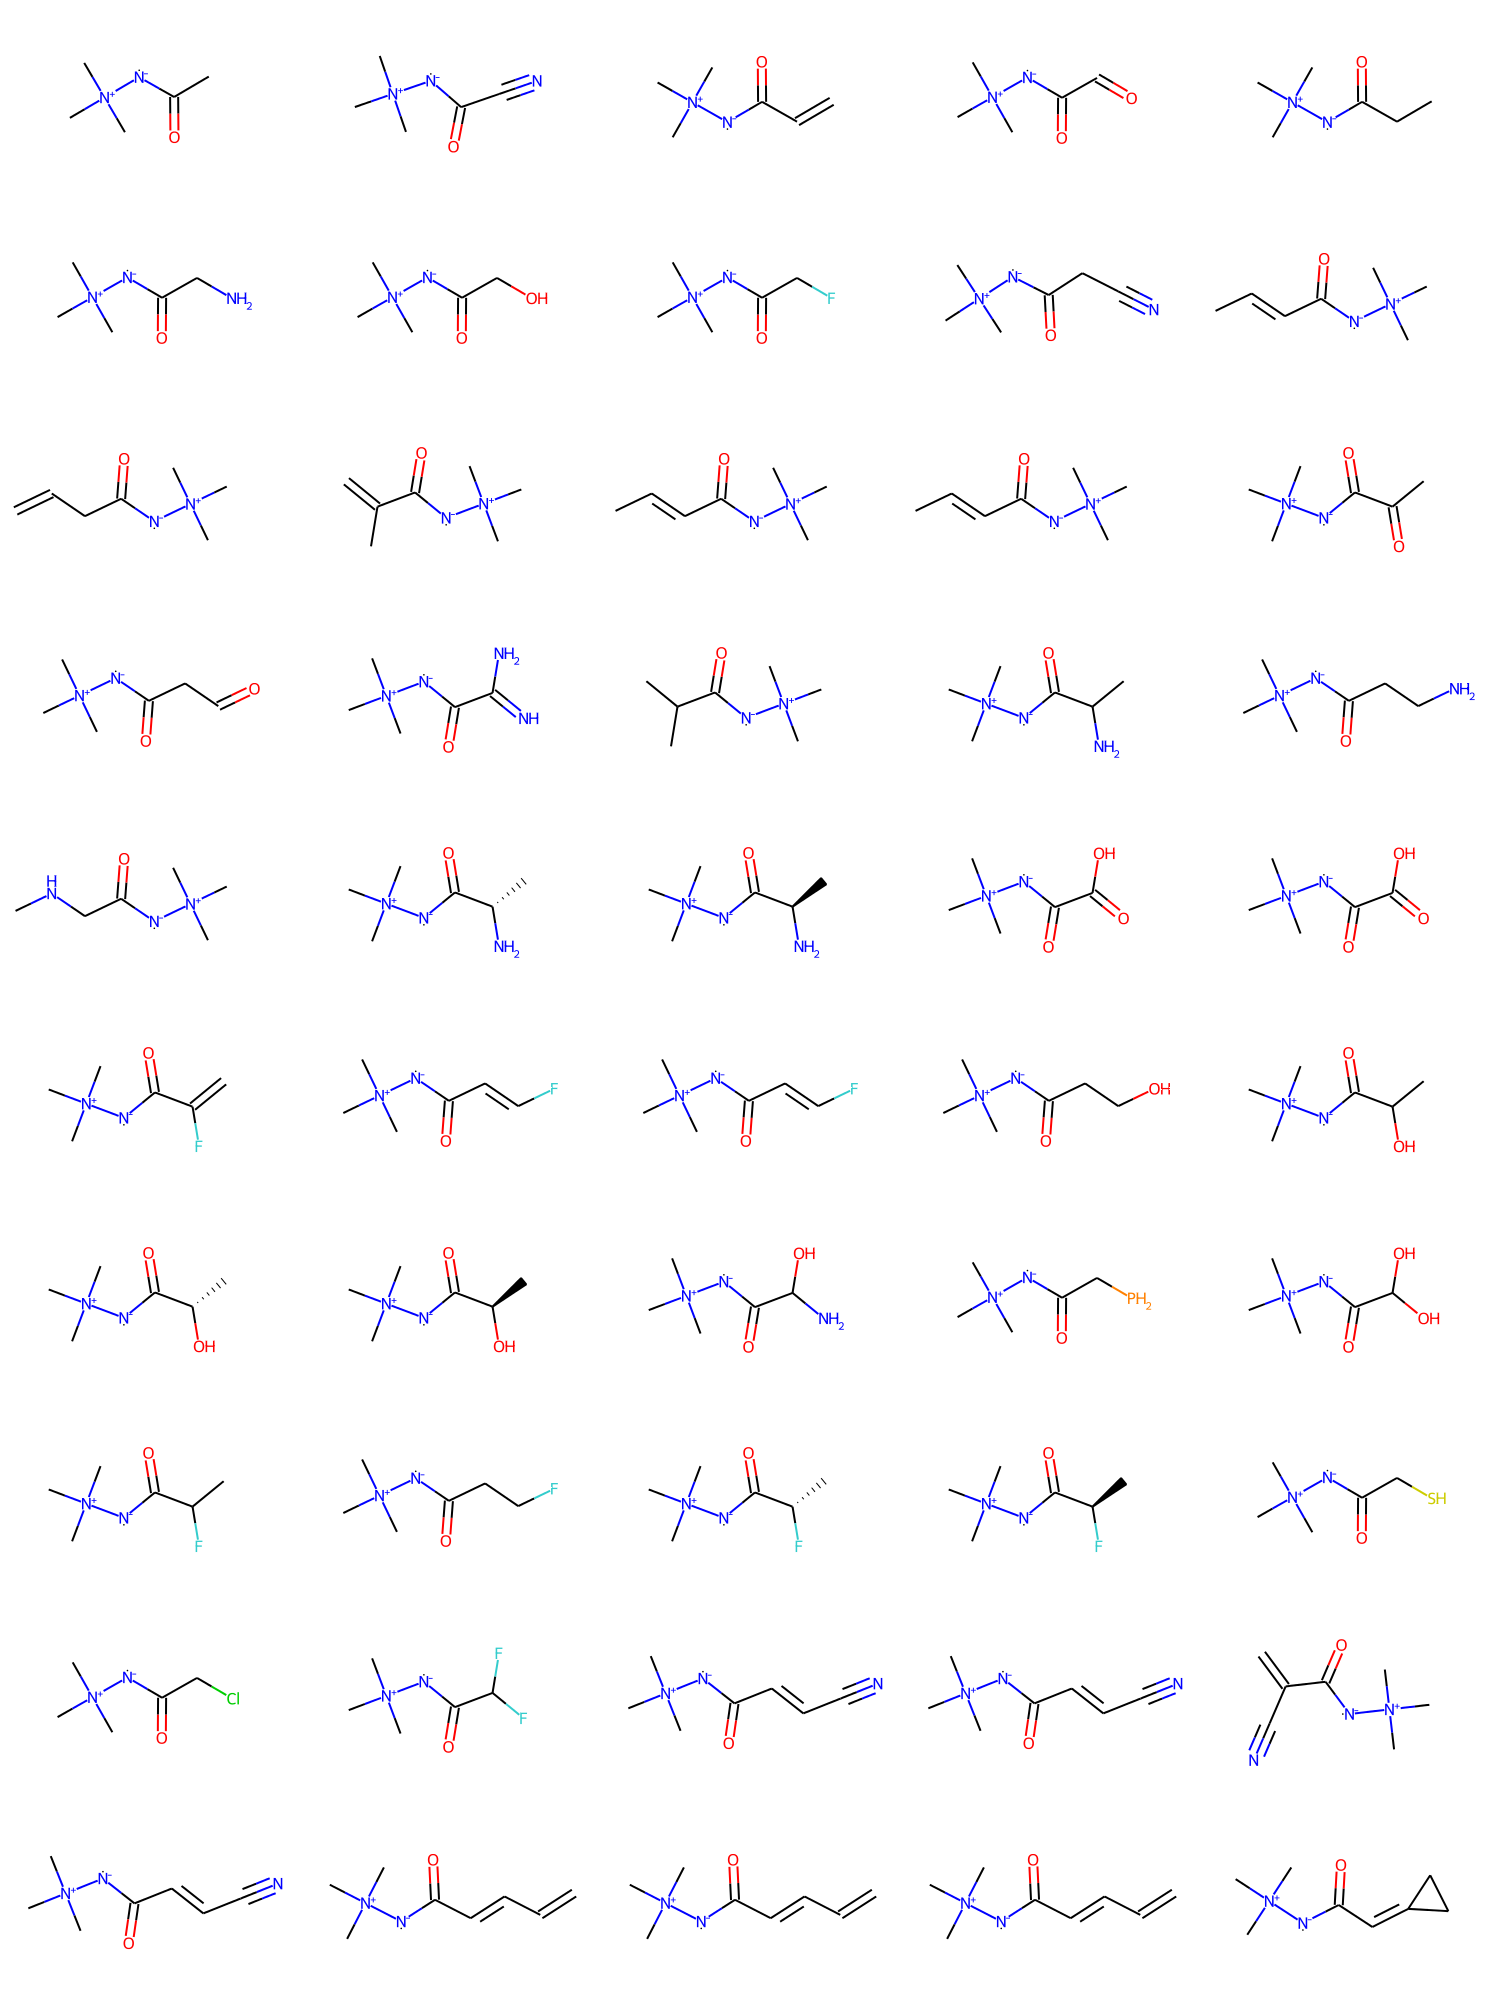

In [29]:
Chem.Draw.MolsToGridImage(ylides, molsPerRow=5,subImgSize=(300,200))

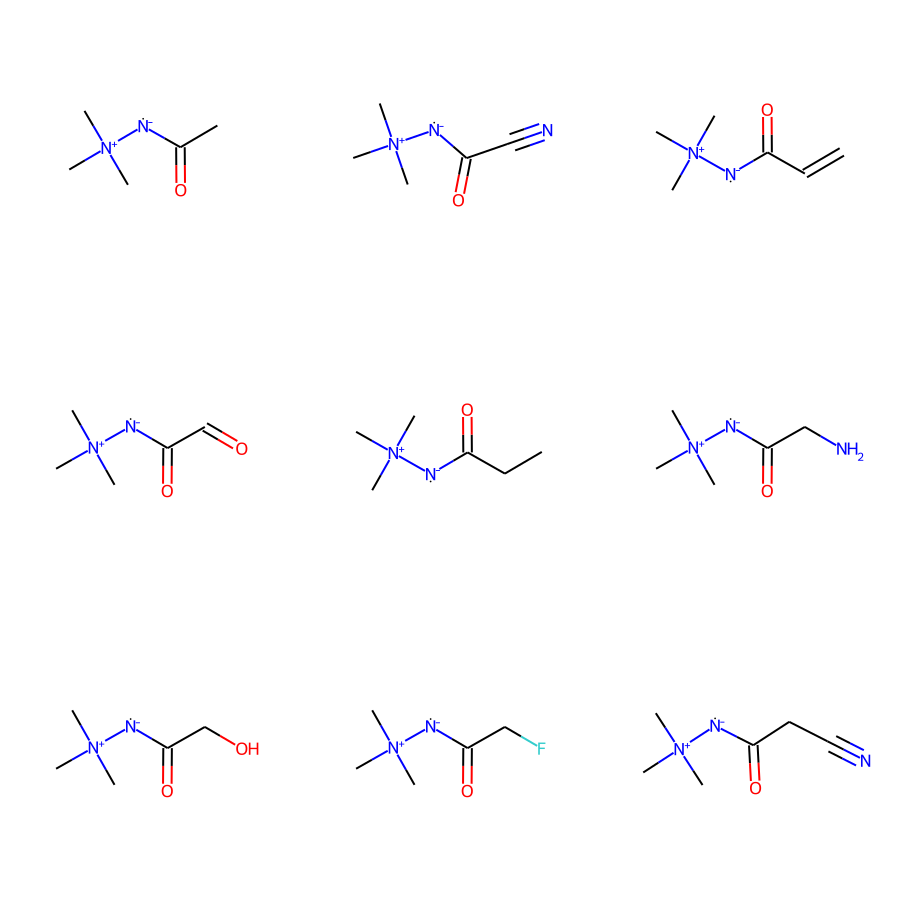

In [45]:
mcb= [Chem.Mol(i.ToBinary()) for i in ylides[0:20]]
size=(300,300)
#mcb= [Chem.Kekulize(i) for i in mcb]
#mcb= [rdDepictor.Compute2DCoords(i) for i in mcb]
drawer = rdMolDraw2D.MolDraw2DSVG(size[0]*3,size[1]*3,size[0],size[1])
drawer.DrawMolecules(mcb)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
svg.replace('svg:','')
SVG(svg)

In [46]:
with tempfile.NamedTemporaryFile(delete=True) as tmp:
    tmp.write(svg.encode())
    tmp.flush()
    svg2png(url=tmp.name, write_to="../Figures/mol_img.png",dpi=1000,scale=3.0)

In [21]:
period_count=0

for i,s in enumerate(noble_acids):
    if '.' in s:
        print(f'Smiles {s} at position {i} is two molecules')
        period_count+=1

print(period_count)

0


In [51]:
df_ylides=pd.DataFrame(list(zip(ylide_smiles,ylide_rad_smiles,ylide_h_smiles)),columns=['Ylides', 'Ylides Rad','Ylides H'])

In [52]:
df_ylides

,Ylides,Ylides Rad,Ylides H
0,CC(=O)[N-][N+](C)(C)C,CC(=O)[N][N+](C)(C)C,CC(=O)[NH][N+](C)(C)C
1,C[N+](C)(C)[N-]C(=O)C#N,C[N+](C)(C)[N]C(=O)C#N,C[N+](C)(C)[NH]C(=O)C#N
2,C=CC(=O)[N-][N+](C)(C)C,C=CC(=O)[N][N+](C)(C)C,C=CC(=O)[NH][N+](C)(C)C
3,C[N+](C)(C)[N-]C(=O)C=O,C[N+](C)(C)[N]C(=O)C=O,C[N+](C)(C)[NH]C(=O)C=O
4,CCC(=O)[N-][N+](C)(C)C,CCC(=O)[N][N+](C)(C)C,CCC(=O)[NH][N+](C)(C)C
...,...,...,...
19092,Cc1[nH]c2ccc(Cl)cc2c(=O)c1CC(=O)[N-][N+](C)(C)C,Cc1[nH]c2ccc(Cl)cc2c(=O)c1CC(=O)[N][N+](C)(C)C,Cc1[nH]c2ccc(Cl)cc2c(=O)c1CC(=O)[NH][N+](C)(C)C
19093,C[N+](C)(C)[N-]C(=O)CCc1cc(=O)[nH]c2ccc(Cl)cc12,C[N+](C)(C)[N]C(=O)CCc1cc(=O)[nH]c2ccc(Cl)cc12,C[N+](C)(C)[NH]C(=O)CCc1cc(=O)[nH]c2ccc(Cl)cc12
19094,Cc1c(CC(=O)[N-][N+](C)(C)C)nnn1-c1ccc(Cl)cc1,Cc1c(CC(=O)[N][N+](C)(C)C)nnn1-c1ccc(Cl)cc1,Cc1c(CC(=O)[NH][N+](C)(C)C)nnn1-c1ccc(Cl)cc1
19095,CC(C(=O)[N-][N+](C)(C)C)c1ccc(N2CC=CC2)c(Cl)c1,CC(C(=O)[N][N+](C)(C)C)c1ccc(N2CC=CC2)c(Cl)c1,CC(C(=O)[NH][N+](C)(C)C)c1ccc(N2CC=CC2)c(Cl)c1


In [53]:
df_ylides.to_csv('Ylides_YlideRads_Cleaned.csv')

## Esters

## Amides

## Benzyl